# Chapter 7 Lab 2

## Goal
In this lab, we will continue to use the DoTalicious data set from previous labs. Using KNN for classification, we will attempt to predict a player's SkillLevel. If you remember, the raw data represents skill level with numbers between 0 and 3 with 0 being Novice and 3 being Expert. We would expect a player's SkillLevel to be a reflection of their other stats such as Kills and Deaths.

Scikit-learn has a KNeighborsClassifier package that we will use. We will combine this with RepeatedKFold and GridSearchCV in order to explore different values of K all at once.

## Preparation

Load the required packages below.

In [56]:
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, make_scorer, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [57]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [58]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

Notice that we will need to change some data types.

In [59]:
dota_df1[' TotalTime'] = pd.to_numeric(dota_df1[' TotalTime'], errors='coerce')

We'll make a quick fix to an odd value in SkillLevel too. Here, we'll remove the row.

In [60]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

In [61]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        867 non-null    float64
dtypes: float64(3), int64(12), object(1)
memory u

Lastly, let's work on the SkillLevel column! We need to change it to categorical.

In [62]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GamesPlayed       868 non-null    int64   
 1   GamesWon          868 non-null    int64   
 2   GamesLeft         868 non-null    int64   
 3   Ditches           868 non-null    int64   
 4   Points            868 non-null    float64 
 5   SkillLevel        868 non-null    category
 6   Kills             868 non-null    int64   
 7   KillsPerMin       868 non-null    float64 
 8    Deaths           868 non-null    int64   
 9   Assists           868 non-null    int64   
 10  CreepsKilled      868 non-null    int64   
 11  CreepsDenied      868 non-null    int64   
 12   NeutralsKilled   868 non-null    int64   
 13   TowersDestroyed  868 non-null    int64   
 14   RaxsDestroyed    868 non-null    int64   
 15   TotalTime        867 non-null    float64 
dtypes: category(1), float64(3)

Next, let's check for null values and remove those.

In [63]:
dota_df1.isna().sum().sum()

1

In [64]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,0,0,0.0,0,0,0,0,0,0,0,NaN


In [65]:
dota_df1.drop([517], inplace=True)

In [66]:
dota_df1.isna().sum().sum()

0

Lastly, a little clean up in the column names.

In [67]:
dota_df1 = dota_df1.rename(columns=lambda x: x.strip())
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 0 to 867
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GamesPlayed      867 non-null    int64   
 1   GamesWon         867 non-null    int64   
 2   GamesLeft        867 non-null    int64   
 3   Ditches          867 non-null    int64   
 4   Points           867 non-null    float64 
 5   SkillLevel       867 non-null    category
 6   Kills            867 non-null    int64   
 7   KillsPerMin      867 non-null    float64 
 8   Deaths           867 non-null    int64   
 9   Assists          867 non-null    int64   
 10  CreepsKilled     867 non-null    int64   
 11  CreepsDenied     867 non-null    int64   
 12  NeutralsKilled   867 non-null    int64   
 13  TowersDestroyed  867 non-null    int64   
 14  RaxsDestroyed    867 non-null    int64   
 15  TotalTime        867 non-null    float64 
dtypes: category(1), float64(3), int64(12)
memory

## Step 2: Set up training and testing set and preprocess

Now that we've got some nice data, normally we would consider scaling it. Not so fast!

Why?

We will indeed standard scale the data - but we must first split the data into two sets - training and testing. When you standardize the entire data set together, you are using statistical parameters for the whole data set to standardize to as well. In order words, to standarize the KillsPerMin column, we'd us ALL values in that column so that each individual value in the new, standardized column has a little bit of all its "buddies" in that column in it. They've "rubbed off" on each other.

Now, using the concept of training a model on the training data and then testing it on unseen test data, if we did standardize the entire data set before splitting, the training set would have been "exposed" already to the test set then they "rubbed off" on each other.

So, the first step is to split the data into two pieces of two parts each: first into X, y for predictors and target respectively and then train (X,y) and test (X,y).

Keep in mind, there is a mild debate about whether or not you should also scale the y (target) data because in doing so, you lose interpretability but in not doing so you do NOT usually lose any model quality.

Here, we will only standardize the independent variables (aka predictors or X).

In [68]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

We set 'test_size' to 0.25, which means the training data size will be 75% of the original data sets X and y.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [70]:
scaler = StandardScaler()
Xtrn_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
Xtst_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

## Step 3: Apply the KNN Classifier

To follow the same methodology in the R labs, we must execute several steps.

1. To establish the same as 'repeatedcv' we use RepeatedKFold with 10 splits and 3 repeats.
2. We instantiate the KNN object and create a list of K's through which we will iterate.
3. Lastly, we use GridSearchCV to apply the KNN model to our data over the range of possible K's that we've specified but also applying RepeatedKFold (setting 'cv' to do so) and lastly ranking the results according to Accuracy.

Notice the since we are trying different parameters, we don't fit the KNN model directly to our data - we could do that if we had already picked a value for K. Instead, the KNN model is a parameter of GridSearchCV and we fit the data using GridSearchCV.

In [71]:
#define a new scorer
def kappa_scorer(est, X, y):
    y_pred = est.predict(X)
    kappa = cohen_kappa_score(y, y_pred)
    return kappa
    


In [72]:
#Setup and configure settings for Repeated k-Fold CV (k-folds=10, repeats=10)
rcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=101)

#define model
knn = KNeighborsClassifier()
scoring = {'Accuracy':'accuracy', 'Kappa':make_scorer(cohen_kappa_score)}
k_list = list(range(5, 44, 2))
params = dict(n_neighbors=k_list)

#create model, perform Repeated CV and evaluate model
scores = GridSearchCV(knn, params, scoring=scoring, cv=rcv, refit='Accuracy', n_jobs=-1)
scores.fit(Xtrn_scaled, y_train)
#scores.predict(Xtrn_scaled)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=101),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43]},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'Kappa': make_scorer(cohen_kappa_score)})

In [73]:
cv_df = pd.DataFrame(scores.cv_results_)
cv_res_df = pd.DataFrame(cv_df[['param_n_neighbors', 'mean_test_Accuracy', 'mean_test_Kappa']])
cv_res_df.rename(columns = {'param_n_neighbors' : 'K', 'mean_test_Accuracy' : 'Accuracy', 'mean_test_Kappa' : 'Kappa'}, inplace=True)
cv_res_df
                        

,K,Accuracy,Kappa
0,5,0.853846,0.712507
1,7,0.847179,0.697206
2,9,0.841026,0.685140
3,11,0.841026,0.684419
4,13,0.837436,0.676974
5,15,0.835897,0.674149
6,17,0.835897,0.674335
7,19,0.832821,0.667529
8,21,0.828718,0.659306
9,23,0.824103,0.649972


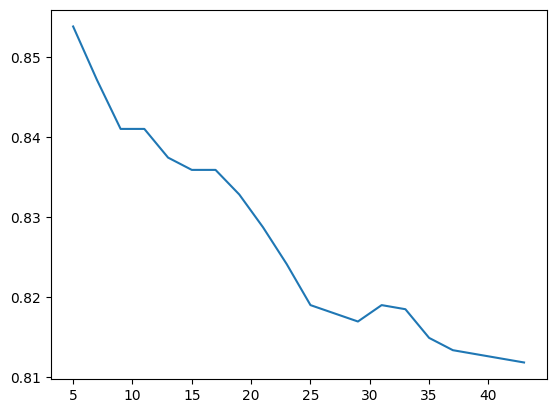

In [74]:
plt.plot(cv_res_df['K'], cv_res_df['Accuracy']);

In [75]:
scores.best_params_

{'n_neighbors': 5}

The resulting dataframe and plot show K=5 to be our optimal. Of course, in Python you can skip all of that and simply ask it to give you the optimal K by calling "best_params_" as we did immediately above. Not surprisingly, it tells us K=5 as well.

At this point, to produce a confusion matrix, we need y_test and y_predicted (from our fitted model).

We will not have to re-instantiate the model and specify K=5. Instead, we call the 'best_estimator_' and predict using that. The best estimator we found was when K=5.

In [76]:
final_model = scores.best_estimator_
knn_pred = final_model.predict(Xtst_scaled)

The most common way to evaluate classification visually is with a confusion matrix. Bascially, if you predict skill level 0 and the original 'true' label was 0, then you have a true positive. Depending on your intent, this might be what you're hoping to maximize.

You will explore the types of metrics in Chapter 8 in more detail.

Below is a confusion matrix.

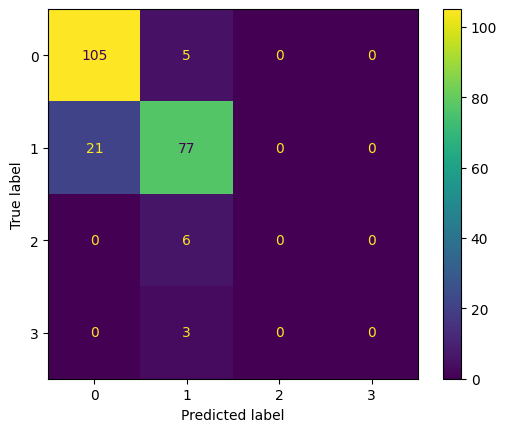

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)
plt.show()

In R, the output is much more detailed. Python produces a report that is more focused on the three metrics you will use most often. Again, you will see these in more detail in the next chapter.

'Support' is simply the total number of observations for each particular class. So, for the first line, 'class 0' there are 110 observations.

In [78]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, knn_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.95      0.89       110
     class 1       0.85      0.79      0.81        98
     class 2       0.00      0.00      0.00         6
     class 3       0.00      0.00      0.00         3

    accuracy                           0.84       217
   macro avg       0.42      0.44      0.43       217
weighted avg       0.80      0.84      0.82       217



We can also call up the Kappa separately if we're worried about an imbalance.

In [79]:
cohen_kappa_score(y_test, knn_pred)

0.6875899798445149

Lastly, R focuses on 'specificity' and 'sensitivity'. These are actually two forms of 'recall'. Recall of a positive class is sensitivity while recall of a negative class is specificity.

The issue is that this works in binary classification only. For present purposes, we can manipulate the predicted data into a binary for each class we have and then call up specificity and sensitivity.

In [80]:
from sklearn.metrics import precision_recall_fscore_support
prfs = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test).astype(float)==l, np.array(knn_pred.astype(float))==l, pos_label=True,average=None)
    prfs.append([recall[1],recall[0]])

pd.DataFrame(prfs, columns = ['sensitivity','specificity']).transpose()

,0,1,2,3
sensitivity,0.954545,0.785714,0.0,0.0
specificity,0.803738,0.882353,1.0,1.0


Lastly, when we say our metrics are 'good', what do we mean? Usually, we're comparing to some standard. If our accuracy is 80% but throwing darts at a dartboard that is divided into sections representing our classes gets us 85% accuracy, our model isn't all that meaningful!

In this case, we create a baseline model - in Python it's called 'DummyClassifier'. In R, it is 'nullmodel'.

In [81]:
dummy_mod = DummyClassifier(strategy='most_frequent')
dummy_mod.fit(Xtrn_scaled, y_train)


DummyClassifier(strategy='most_frequent')

In [82]:
dummy_mod.score(Xtrn_scaled, y_train)

0.5169230769230769

So our dummy model gets us a score of 51% accuracy. The efforts we took with our model took us to 84%. It is safe to say that the model is an improvement over the base case!